In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import os
import shutil
import random


from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [6]:

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

fer_train_gen = datagen.flow_from_directory(
    '/kaggle/input/face-expression-recognition-dataset/images/train',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

fer_test_gen = datagen.flow_from_directory(
    '/kaggle/input/face-expression-recognition-dataset/images/validation',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)



Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [7]:

dataset_dir = '/kaggle/input/ckplus/CK+48'
train_dir = '/kaggle/working/output/ck+/train'
test_dir = '/kaggle/working/output/ck+/test'


split_ratio = 0.8


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for emotion in os.listdir(dataset_dir):
    if emotion in ['contempt']:  # Skip 'Contempt' as the other datasets dosen't have this class
        continue
    
    emotion_dir = os.path.join(dataset_dir, emotion)
    images = os.listdir(emotion_dir)
    
    
    random.shuffle(images)
    split_point = int(len(images) * split_ratio)
    train_images = images[:split_point]
    test_images = images[split_point:]
    

    os.makedirs(os.path.join(train_dir, emotion), exist_ok=True)
    os.makedirs(os.path.join(test_dir, emotion), exist_ok=True)
    

    for img in train_images:
        shutil.copy(os.path.join(emotion_dir, img), os.path.join(train_dir, emotion, img))
    

    for img in test_images:
        shutil.copy(os.path.join(emotion_dir, img), os.path.join(test_dir, emotion, img))


In [8]:


print(os.listdir('/kaggle/working/output/ck+/train'))
print(os.listdir('/kaggle/working/output/ck+/test'))

['surprise', 'anger', 'disgust', 'sadness', 'happy', 'fear']
['surprise', 'anger', 'disgust', 'sadness', 'happy', 'fear']


In [9]:

train_dir = '/kaggle/working/output/ck+/train'
for emotion in os.listdir(train_dir):
    emotion_dir = os.path.join(train_dir, emotion)
    print(f"{emotion}: {len(os.listdir(emotion_dir))} images")


test_dir = '/kaggle/working/output/ck+/test'
for emotion in os.listdir(test_dir):
    emotion_dir = os.path.join(test_dir, emotion)
    print(f"{emotion}: {len(os.listdir(emotion_dir))} images")

surprise: 199 images
anger: 108 images
disgust: 141 images
sadness: 67 images
happy: 165 images
fear: 60 images
surprise: 50 images
anger: 27 images
disgust: 36 images
sadness: 17 images
happy: 42 images
fear: 15 images


In [10]:
ck_train_gen = datagen.flow_from_directory(
    '/kaggle/working/output/ck+/train',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    classes=['angry', 'disgust', 'fear', 'happy', 'sadness', 'surprise']  # Exclude 'Contempt'
)

ck_test_gen = datagen.flow_from_directory(
    '/kaggle/working/output/ck+/test',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    classes=['angry', 'disgust', 'fear', 'happy', 'sadness', 'surprise']  # Exclude 'Contempt'
)


Found 632 images belonging to 6 classes.
Found 160 images belonging to 6 classes.


In [11]:
raf_train_gen = datagen.flow_from_directory(
    '/kaggle/input/raf-db-dataset/DATASET/train',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

raf_test_gen = datagen.flow_from_directory(
    '/kaggle/input/raf-db-dataset/DATASET/test',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)


Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


In [12]:
def pad_labels(batch, num_classes=7):
    images, labels = batch
    if labels.shape[1] < num_classes:
        padding = np.zeros((labels.shape[0], num_classes - labels.shape[1]))
        labels = np.concatenate([labels, padding], axis=1)
    return images, labels


def combined_generator(*gens):
    while True:
        batches = [next(gen) for gen in gens]
        padded_batches = [pad_labels(batch, num_classes=7) if batch[1].shape[1] < 7 else batch for batch in batches]
        images = np.concatenate([batch[0] for batch in padded_batches], axis=0)
        labels = np.concatenate([batch[1] for batch in padded_batches], axis=0)
        yield images, labels

train_gen = combined_generator(fer_train_gen, ck_train_gen, raf_train_gen)
test_gen = combined_generator(fer_test_gen, ck_test_gen, raf_test_gen)


In [13]:
nb_classes = 7

model = Sequential()
model.add(Input(shape=(48, 48, 1)))

# 1 - Convolution layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd Convolution layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(256, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(126))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(nb_classes, activation='softmax'))


print(model.summary())

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 126)            │        64,638 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126)            │           504 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,682,927 (21.68 MB)

 Trainable params: 5,680,755 (21.67 MB)

 Non-trainable params: 2,172 (8.48 KB)

None


In [14]:
checkpoint = ModelCheckpoint("./model.keras", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max' )

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.5,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0
                                        )

callbacks_list = [checkpoint, early_stopping, reduce_learning_rate]

In [15]:
fer_train_samples = fer_train_gen.samples
ck_train_samples = ck_train_gen.samples
raf_train_samples = raf_train_gen.samples

fer_val_samples = fer_test_gen.samples
ck_val_samples = ck_test_gen.samples
raf_val_samples = raf_test_gen.samples

# Calculate the total samples
train_samples = fer_train_samples + ck_train_samples + raf_train_samples
val_samples = fer_val_samples + ck_val_samples + raf_val_samples

# Batch size
batch_size = 64

#Epochs
epochs = 100

# Calculate steps per epoch and validation steps
epoch_steps = np.ceil(train_samples / batch_size).astype(int)
val_steps = np.ceil(val_samples / batch_size).astype(int)

print(f"Steps per epoch: {epoch_steps}")
print(f"Validation steps: {val_steps}")

Steps per epoch: 652
Validation steps: 161


In [16]:


history = model.fit(
    train_gen,  
    steps_per_epoch= epoch_steps,
    epochs=epochs,
    validation_data=test_gen,  
    validation_steps=val_steps, 
    callbacks=callbacks_list
)

Epoch 1/100
  2/652 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.1419 - loss: 2.3153   

I0000 00:00:1724338644.564005     172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724338644.593471     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/652 ━━━━━━━━━━━━━━━━━━━━ 21:19 2s/step - accuracy: 0.1659 - loss: 2.3212

W0000 00:00:1724338666.467971     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


194/652 ━━━━━━━━━━━━━━━━━━━━ 7:48 1s/step - accuracy: 0.2321 - loss: 2.1009 

W0000 00:00:1724338841.876513     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


453/652 ━━━━━━━━━━━━━━━━━━━━ 2:40 808ms/step - accuracy: 0.2692 - loss: 1.9843

W0000 00:00:1724339009.843825     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.2890 - loss: 1.9265

W0000 00:00:1724339071.958346     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724339155.736371     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


652/652 ━━━━━━━━━━━━━━━━━━━━ 544s 803ms/step - accuracy: 0.2891 - loss: 1.9263 - val_accuracy: 0.3778 - val_loss: 1.8017 - learning_rate: 1.0000e-04
Epoch 2/100
  1/652 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - accuracy: 0.4427 - loss: 1.4686

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


310/652 ━━━━━━━━━━━━━━━━━━━━ 1:56 340ms/step - accuracy: 0.4316 - loss: 1.5340

W0000 00:00:1724339272.696125     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


652/652 ━━━━━━━━━━━━━━━━━━━━ 247s 380ms/step - accuracy: 0.4406 - loss: 1.5086 - val_accuracy: 0.4757 - val_loss: 1.4327 - learning_rate: 1.0000e-04
Epoch 3/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 223s 342ms/step - accuracy: 0.4954 - loss: 1.3522 - val_accuracy: 0.4759 - val_loss: 1.3907 - learning_rate: 1.0000e-04
Epoch 4/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 195s 299ms/step - accuracy: 0.5316 - loss: 1.2552 - val_accuracy: 0.5779 - val_loss: 1.1567 - learning_rate: 1.0000e-04
Epoch 5/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 186s 285ms/step - accuracy: 0.5553 - loss: 1.1912 - val_accuracy: 0.5445 - val_loss: 1.2088 - learning_rate: 1.0000e-04
Epoch 6/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 204s 313ms/step - accuracy: 0.5789 - loss: 1.1299 - val_accuracy: 0.6215 - val_loss: 1.0438 - learning_rate: 1.0000e-04
Epoch 7/100
600/652 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.5955 - loss: 1.0881

W0000 00:00:1724340420.786646     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


652/652 ━━━━━━━━━━━━━━━━━━━━ 205s 315ms/step - accuracy: 0.5959 - loss: 1.0872 - val_accuracy: 0.5983 - val_loss: 1.0607 - learning_rate: 1.0000e-04
Epoch 8/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 205s 315ms/step - accuracy: 0.6114 - loss: 1.0477 - val_accuracy: 0.6394 - val_loss: 0.9900 - learning_rate: 1.0000e-04
Epoch 9/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 204s 313ms/step - accuracy: 0.6201 - loss: 1.0244 - val_accuracy: 0.6244 - val_loss: 1.0080 - learning_rate: 1.0000e-04
Epoch 10/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 203s 312ms/step - accuracy: 0.6303 - loss: 0.9951 - val_accuracy: 0.6533 - val_loss: 0.9420 - learning_rate: 1.0000e-04
Epoch 11/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 207s 317ms/step - accuracy: 0.6412 - loss: 0.9704 - val_accuracy: 0.6478 - val_loss: 0.9383 - learning_rate: 1.0000e-04
Epoch 12/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6465 - loss: 0.9512

W0000 00:00:1724341448.724030     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


652/652 ━━━━━━━━━━━━━━━━━━━━ 206s 316ms/step - accuracy: 0.6465 - loss: 0.9512 - val_accuracy: 0.6363 - val_loss: 0.9839 - learning_rate: 1.0000e-04
Epoch 13/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 201s 308ms/step - accuracy: 0.6556 - loss: 0.9298 - val_accuracy: 0.6704 - val_loss: 0.8795 - learning_rate: 1.0000e-04
Epoch 14/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 203s 312ms/step - accuracy: 0.6611 - loss: 0.9143 - val_accuracy: 0.6422 - val_loss: 0.9568 - learning_rate: 1.0000e-04
Epoch 15/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 206s 316ms/step - accuracy: 0.6660 - loss: 0.9039 - val_accuracy: 0.6900 - val_loss: 0.8459 - learning_rate: 1.0000e-04
Epoch 16/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 202s 311ms/step - accuracy: 0.6717 - loss: 0.8864 - val_accuracy: 0.6645 - val_loss: 0.9030 - learning_rate: 1.0000e-04
Epoch 17/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 202s 310ms/step - accuracy: 0.6742 - loss: 0.8756 - val_accuracy: 0.6750 - val_loss: 0.8709 - learning_rate: 1.0000e-04
Epoch 18/100
652/652 ━━━━━━━━━━━━━━━━━━━━

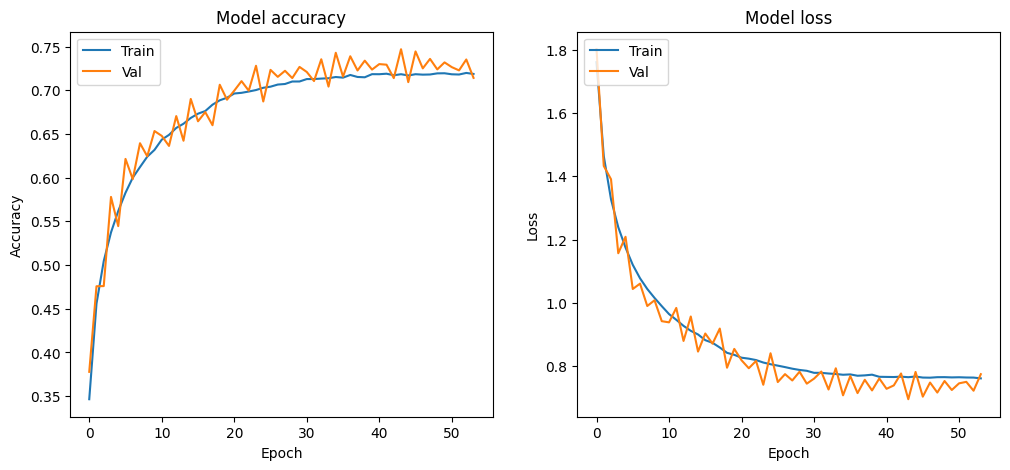

In [17]:

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.show()

plot_history(history)


In [18]:
val_accuracy = history.history['val_accuracy']  # Extract validation accuracy for all epochs
best_epoch = np.argmax(val_accuracy)  # Get the index of the epoch with the best validation accuracy
best_val_accuracy = val_accuracy[best_epoch]

print(f"Best Epoch: {best_epoch + 1} with Validation Accuracy: {best_val_accuracy:.4f}")

Best Epoch: 44 with Validation Accuracy: 0.7470


In [19]:
model.save('best_model_after_training_new.keras')

In [20]:
from tensorflow.keras.models import load_model

model.load_model('best_model_after_training_07788.h5')

AttributeError: 'Sequential' object has no attribute 'load_model'